<a href="https://colab.research.google.com/github/shubhamByte/Machine-Learning/blob/main/Tensorflow_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
# constants

a = tf.constant(4)
b = tf.constant(5)
c = a+b

# no requirement to run session in tensorflow 2.0 and above. now eager mode is default
# sess = tf.Session()
# sess.run(c)

print(c.numpy())

a = tf.constant([[4,2]])
b = tf.constant([[1],[3]])

res = tf.matmul(a,b)
print(res.numpy())


9
[[10]]


In [3]:
# if you want to use session and placeholder now, use in this way..

# tf.compat.v1.disable_eager_execution()

# a = tf.constant(4)
# b = tf.constant(5)
# c = a + b

# with tf.compat.v1.Session() as sess:
#   print(sess.run(c))


In [4]:
# Variables

a = tf.Variable(10)
print(a.numpy())

a.assign(20)
a.numpy()

10


20

# MNIST DATASET MODEL

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from tensorflow import keras

(x_train, y_train), (x_test, y_test)= keras.datasets.mnist.load_data()

x_train.shape, y_train.shape, x_train.dtype

((60000, 28, 28), (60000,), dtype('uint8'))

In [7]:
# Reshaping the input data
x_train = tf.reshape(x_train,[-1,784])
x_test = tf.reshape(x_test,[-1,784])

x_train.shape, x_test.shape

(TensorShape([60000, 784]), TensorShape([10000, 784]))

In [8]:
# reshaping output data to one hot vector
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [9]:
# changing data to tf.float32 since all the weights and biases are in tf.float2
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.cast(y_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)

float64


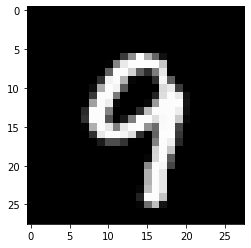

In [10]:
# viewing one sample image

sample_img = tf.reshape(x_train[550],[28,28]) 

# from array of unit8 type to numpy array of float type
sample_img = np.array(sample_img, dtype = 'float')

print(sample_img.dtype)
plt.imshow(sample_img,cmap='gray')
plt.show()

In [11]:
# Architecture of neural network

# nodes
n_input = 784
n_hidden1 = 256
n_hidden2 = 256
n_output = 10

# weights and  biases

weights = {
    'h1' : tf.Variable(tf.random.normal([n_input,n_hidden1])),
    'h2' : tf.Variable(tf.random.normal([n_hidden1,n_hidden2])),
    'out' : tf.Variable(tf.random.normal([n_hidden2,n_output]))
}

biases = {
    'h1' : tf.Variable(tf.random.normal([n_hidden1])),
    'h2' : tf.Variable(tf.random.normal([n_hidden2])),
    'out' : tf.Variable(tf.random.normal([n_output]))
}

# 'h1' : tf.Variable(tf.random.normal([n_input,n_hidden1]), trainable= False) can be used if we don't want any variable to get trained. default is true

In [12]:
weights['h1'].dtype

tf.float32

In [13]:
# forward propogation

def forward_propogation(x,weights,biases):

  in_layer1 = tf.matmul(x,weights['h1']) + biases['h1']
  out_layer1 = tf.nn.relu(in_layer1)

  in_layer2 = tf.matmul(out_layer1,weights['h2']) + biases['h2']
  out_layer2 = tf.nn.relu(in_layer2)

  output = tf.matmul(out_layer2,weights['out']) + biases['out']

  return output




---

these steps are testing what happens when we forward prpogate our data with random weights. Accuracy should be around 10% for 10 classes. After training the model, we can rerun it to check accuracy again.

In [14]:
# predictions without training the model
x = x_train
y = y_train

pred = forward_propogation(x,weights,biases)


In [15]:
# Loss / Cost
# first logits calculated on prediction -> softmax -> cross entropy

loss = tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y) # gives an array
loss.numpy(), loss.shape

(array([581331.56,      0.  , 637413.9 , ..., 642419.75, 675667.7 ,
        343129.16], dtype=float32), TensorShape([60000]))

In [16]:
loss = tf.reduce_mean(loss)   # taking mean of the array/ can do sum also
loss.numpy()

387447.34

In [17]:
# accuracy
predictions = tf.argmax(pred,axis = 1)
true_labels = tf.argmax(y,axis = 1)
correct_pred = tf.equal(predictions, true_labels)

# predictions, true_labels, correct_pred
result = tf.reduce_sum(tf.cast(correct_pred, tf.int32))
result.numpy()

4201

---
steps without training over. (non essential steps)








# Training our model

The loss should be calculated inside the tf.GradientTape() context, as the purpose of the tf.GradientTape is to record the forward pass operations for the purpose of computing gradients for optimization. The loss function provides a scalar value indicating the degree of difference between the predictions and actual labels, which is then used to update the model parameters during optimization. If the loss calculation is performed outside the tf.GradientTape context, the gradients cannot be computed and the optimization step cannot be performed.

In [19]:
epochs = 30
batch_size = 256
learning_rate = 0.001
learnable_variables = [weights['h1'], weights['h2'], weights['out'], biases['h1'], biases['h2'], biases['out']]

# Total number of samples
total_samples = x_train.shape[0]

# Total number of iterations (steps) per epoch
steps_per_epoch = total_samples // batch_size      # floor divison

# choosing our optimizer
optimizer = tf.optimizers.Adam(learning_rate)

for epoch in range(epochs):

    total_cost = 0

    for step in range(steps_per_epoch):
        # Get the current batch of data
        start = step * batch_size
        end = start + batch_size
        x_batch = x_train[start:end]
        y_batch = y_train[start:end]
        
        # Use tf.GradientTape to record operations
        with tf.GradientTape() as tape:
          
            # Perform forward propagation on the batch of data
            pred = forward_propogation(x_batch, weights, biases)
            # Calculate the loss
            current_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_batch))

        # Use the recorded operations to compute gradients
        grads = tape.gradient(current_loss, learnable_variables)
        
        # Apply gradients to update weights and biases
        optimizer.apply_gradients(zip(grads, learnable_variables))

        total_cost += current_loss
        

    print(f"Epoch: {epoch}, Loss: {total_cost}")


Epoch: 0, Loss: 3256648.0
Epoch: 1, Loss: 1902696.125
Epoch: 2, Loss: 1352318.375
Epoch: 3, Loss: 1021604.625
Epoch: 4, Loss: 798880.375
Epoch: 5, Loss: 635129.875
Epoch: 6, Loss: 515793.375
Epoch: 7, Loss: 416371.40625
Epoch: 8, Loss: 341649.21875
Epoch: 9, Loss: 276058.5625
Epoch: 10, Loss: 226665.65625
Epoch: 11, Loss: 183744.59375
Epoch: 12, Loss: 154888.265625
Epoch: 13, Loss: 123744.0390625
Epoch: 14, Loss: 103769.3125
Epoch: 15, Loss: 82748.109375
Epoch: 16, Loss: 68137.4453125
Epoch: 17, Loss: 50423.03515625
Epoch: 18, Loss: 42729.00390625
Epoch: 19, Loss: 35206.75390625
Epoch: 20, Loss: 30330.28125
Epoch: 21, Loss: 23250.84765625
Epoch: 22, Loss: 18944.943359375
Epoch: 23, Loss: 16182.892578125
Epoch: 24, Loss: 16711.6796875
Epoch: 25, Loss: 11344.3896484375
Epoch: 26, Loss: 11062.0537109375
Epoch: 27, Loss: 10990.7333984375
Epoch: 28, Loss: 11327.52734375
Epoch: 29, Loss: 10902.8681640625


In [20]:
x = x_test
y = y_test
pred = forward_propogation(x,weights,biases)

# accuracy
predictions = tf.argmax(pred,axis = 1)
true_labels = tf.argmax(y,axis = 1)
correct_pred = tf.equal(predictions, true_labels)

result = tf.reduce_sum(tf.cast(correct_pred, tf.int32))
percentage = (result/len(x))*100
print(f'Accuracy is {percentage} %')

Accuracy is 94.57 %
